In [21]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from matplotlib import pyplot
import matplotlib.pyplot as plt

from prediction import LtrPrediction
from processing import DataPreprocessing
import ltr_utils as ut

## Datasets

In [2]:
train = pd.read_csv("../Dataset/train.csv")
test = pd.read_csv("../Dataset/test.csv")
articles = pd.read_csv("../Dataset/articles.csv")
users = pd.read_csv("../Dataset/users.csv")

## Data Preprocessing

In [22]:
data_dict = {
    'train' : '../Dataset/train.csv',
    'test' : '../Dataset/test.csv',
    'articles' : '../Dataset/articles.csv',
    'users' : '../Dataset/users.csv'
}

In [23]:
DataPrep = DataPreprocessing(data_dict)

(11020, 18) (25672, 18)


In [25]:
DataPrep.init_KG('outputs/KGs/KG_dep_parsing_100terms.txt')

In [26]:
DataPrep.init_SentenceTransformer('all-MiniLM-L6-v2')

In [27]:
train_data_df, test_data_df = DataPrep.fit_data_pipeline()

100%|██████████| 25672/25672 [13:27<00:00, 31.78it/s]
/home/simsim/anaconda3/envs/mysdnn/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)
100%|██████████| 11020/11020 [02:27<00:00, 74.78it/s]


In [28]:
processed_data_dict = DataPrep.get_train_test_split(['art','usr','kg'])

87
(25672, 87) (25672, 1) (11020, 87) (11020, 1)


In [29]:
X_train, y_train, groups_train, qid_train, X_test, y_test, qid_test, groups_test = processed_data_dict['train_test']
test_data = processed_data_dict['test_data']

## Model Training

In [30]:
xgb_params = {  'booster':"gbtree", 
                'objective':"rank:pairwise",
                'tree_method':"gpu_hist", 
                'sampling_method':"gradient_based",
                'eval_metric':['map@10'],
             }

model = xgb.XGBRanker(**xgb_params)


model.fit(X_train, y_train, group=groups_train, eval_set=[(X_train, y_train),(X_test, y_test)], eval_group=[groups_train,groups_test],  verbose=False)

result = model.evals_result()
train_score = np.mean(result['validation_0']['map@10'])
test_score = np.mean(result['validation_1']['map@10'])
print('default Train :  ', train_score)
print('default Test  :  ', test_score)

default Train :   0.38357647
default Test  :   0.17101716000000003


## Hyperparameter Tuning

In [31]:
def objective(trial):

        metric = "map@10"

        tuning_params = {
                    "max_depth": trial.suggest_int("max_depth", 2, 8, step=1),
                    "subsample": trial.suggest_float("subsample", 0.5, 0.8, step=0.05),
                    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8, step=0.05),
                    "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10.0, step=0.01),
                    "alpha": trial.suggest_float("alpha", 1e-8, 1.0),
                    "min_child_weight": trial.suggest_float("min_child_weight", 0.01, 10.0, step=0.01),
                    "gamma": trial.suggest_float("gamma", 0.01, 10.0, step=0.01),
                    "max_delta_step":  trial.suggest_float("max_delta_step", 0.01, 10.0, step=0.01),
                    "eta": trial.suggest_float("eta", 0.001, 10.0, step=0.001)

                }
        
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-map@10")

        model = xgb.XGBRanker(booster="gbtree", objective="rank:pairwise",
                            tree_method="gpu_hist", sampling_method="gradient_based",
                            eval_metric=metric,
                            verbosity=1,
                            n_estimators=5000,
                            **tuning_params)

        model.fit(X_train, y_train, group=groups_train, eval_set=[(X_test, y_test)],early_stopping_rounds = 100,  eval_group=[groups_test], callbacks=[pruning_callback],  verbose=False)

        result = model.evals_result()
        opt_score1 = np.mean(result['validation_0'][metric])

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        return opt_score1

# optuna.logging.WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

pruner = optuna.pruners.MedianPruner(n_warmup_steps=20)
study = optuna.create_study(pruner=pruner, direction='maximize')
study.optimize(objective, n_trials=500)

In [32]:
print(f"Optimized MAP: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized MAP: 0.2925
Best params:
	max_depth: 5
	subsample: 0.65
	colsample_bytree: 0.7
	reg_lambda: 4.9799999999999995
	alpha: 0.8810721050769598
	min_child_weight: 0.8200000000000001
	gamma: 6.63
	max_delta_step: 7.14
	eta: 0.001


In [33]:
metric = "map@10"

model_bst = xgb.XGBRanker(booster="gbtree", objective="rank:pairwise",
                        tree_method="gpu_hist", sampling_method="gradient_based",
                        eval_metric=metric,
                        n_estimators=5000,
                        early_stopping_rounds = 50, 
                        verbosity=0,
                        **study.best_params)

model_bst.fit(X_train, y_train, group=groups_train, eval_set=[(X_train, y_train),(X_test, y_test)], eval_group=[groups_train,groups_test],  verbose=False)
result = model_bst.evals_result()
train_score = np.max(result['validation_0']['map@10'])
test_score = np.max(result['validation_1']['map@10'])
print('Optimized Train :  ', train_score)
print('Optimized Test  :  ', test_score)

Optimized Train :   0.272352
Optimized Test  :   0.317065


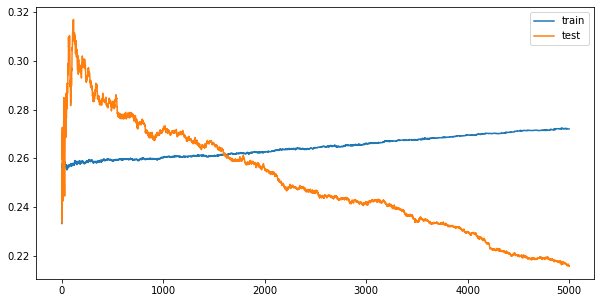

In [34]:
# plot learning curves
pyplot.plot(result['validation_0']['map@10'], label='train')
pyplot.plot(result['validation_1']['map@10'], label='test')
# show the legend
pyplot.legend()
pyplot.rcParams["figure.figsize"] = (10,5)
# show the plot
pyplot.show()

In [41]:
path = 'outputs/kg_DP/'
ut.model_save(model_bst,path,DataPrep)

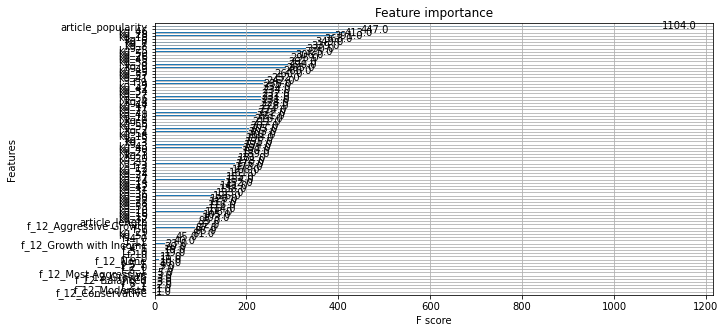

In [ ]:
xgb.plot_importance(model_bst)
plt.show()

## Model Evaluation

In [ ]:
# path = 'outputs/kg_CN/'

# model_bst, DataPrep = ut.load_model(path)

# processed_data_dict = DataPrep.get_train_test_split(['art','usr','kg'])
# X_train, y_train, groups_train, qid_train, X_test, y_test, qid_test, groups_test = processed_data_dict['train_test']
# test_data = processed_data_dict['test_data']

In [ ]:
xgb_Prediction = LtrPrediction(model_bst, test_data)

In [ ]:
results = xgb_Prediction.evaluate()
results

NDCG=0.404 | Recall=0.631 | Precision=0.930 


{'MAP@10': 0.2460986061091103,
 'results@10': {'NDCG': 0.40354546337225977,
  'Recall': 0.6312739910779127,
  'Precision': 0.20413943355119826}}

In [ ]:
top_k_best_score_ips = xgb_Prediction.get_recomendation()

In [ ]:
tcm_le = DataPrep.return_inverse_transform()
top_k_best_score_ips['article_actual_ids'] = top_k_best_score_ips.apply(lambda row: tcm_le.inverse_transform(row['article_actual']) ,axis=1)
top_k_best_score_ips['article_recomended_ids'] = top_k_best_score_ips.apply(lambda row: tcm_le.inverse_transform(row['article_prediction']) ,axis=1)

In [ ]:
pd.set_option('max_columns', None)
pd.set_option('display.max_colwidth', None)
top_k_best_score_ips[['article_actual_ids','article_recomended_ids','apk']].sort_values(by='apk',ascending = False).head(10)

,article_actual_ids,article_recomended_ids,apk
qid,,,
94590770,[tcm:526-22867],"[tcm:526-22867, tcm:526-681575, tcm:526-12174, tcm:526-16645, tcm:526-244935, tcm:526-149043, tcm:526-18025, tcm:526-704480, tcm:526-239640, tcm:526-231792]",1.000000
12488474,"[tcm:526-12174, tcm:526-22867]","[tcm:526-22867, tcm:526-12174, tcm:526-149043, tcm:526-273898, tcm:526-12167, tcm:526-116442, tcm:526-670542, tcm:526-653510, tcm:526-208086, tcm:526-695181]",1.000000
29816351,"[tcm:526-22867, tcm:526-12174]","[tcm:526-22867, tcm:526-12174, tcm:526-149043, tcm:526-782343, tcm:526-93195, tcm:526-191289, tcm:526-10838, tcm:526-249037, tcm:526-239640, tcm:526-153236]",1.000000
93914554,[tcm:526-12174],"[tcm:526-12174, tcm:526-273898, tcm:526-244935, tcm:526-70899, tcm:526-782343, tcm:526-239640, tcm:526-116442, tcm:526-653510, tcm:526-208086, tcm:526-237984]",1.000000
75532794,"[tcm:526-12167, tcm:526-12174, tcm:526-93195]","[tcm:526-12174, tcm:526-12167, tcm:526-244935, tcm:526-93195, tcm:526-782343, tcm:526-16645, tcm:526-70899, tcm:526-418532, tcm:526-695181, tcm:526-13782]",0.916667
31100103,"[tcm:526-782343, tcm:526-22867]","[tcm:526-22867, tcm:526-681575, tcm:526-782343, tcm:526-12174, tcm:526-80807, tcm:526-16645, tcm:526-149043, tcm:526-418532, tcm:526-12167, tcm:526-695181]",0.833333
91243393,"[tcm:526-10787, tcm:526-12167, tcm:526-12174, tcm:526-681575, tcm:526-688510]","[tcm:526-12174, tcm:526-681575, tcm:526-149043, tcm:526-688510, tcm:526-244935, tcm:526-12167, tcm:526-10787, tcm:526-116442, tcm:526-653510, tcm:526-208086]",0.826190
21415256,"[tcm:526-273898, tcm:526-12174, tcm:526-80807]","[tcm:526-12174, tcm:526-782343, tcm:526-273898, tcm:526-80807, tcm:526-16645, tcm:526-239640, tcm:526-153236, tcm:526-116442, tcm:526-237984, tcm:526-164352]",0.805556
47390898,"[tcm:526-273898, tcm:526-12174, tcm:526-418532, tcm:526-492865, tcm:526-681575, tcm:526-22867]","[tcm:526-22867, tcm:526-681575, tcm:526-273898, tcm:526-12174, tcm:526-16645, tcm:526-782343, tcm:526-191289, tcm:526-10838, tcm:526-418532, tcm:526-13782]",0.759259
